# Imports

In [1]:
from scipy.integrate import trapz
from scipy.stats import beta, binom, uniform, gaussian_kde, norm, lognorm
from collections import namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions

In [2]:
def plot_dist(dist, resolution=100, x=None, figsize=(15,5), ax=None, style='r-', label=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    if x is None:
        x = np.linspace(dist.ppf(1/(resolution*2)), dist.ppf(1 - 1/(resolution*2)), resolution)
    ax.plot(x, dist.pdf(x), style, lw=4, alpha=0.6, label=label)
    plt.legend()
    return ax

In [3]:
def multiply_odds(p, odds_multiplier):
    assert 0.0 < float(p) < 1.0
    assert odds_multiplier >= 0
    old_odds = p / (1 - p)
    new_odds = old_odds * odds_multiplier
    new_p = new_odds / (1 + new_odds)
    return new_p

In [4]:
def get_odds_ratio(p_A, p_B):
    odds_A = p_A / (1 - p_A)
    odds_B = p_B / (1 - p_B)
    return odds_A / odds_B

# Template for poisson split test analysis

## Prior on effect size (effective odds ratio)

In [5]:
prior = lognorm(loc=0.5, s=0.2)

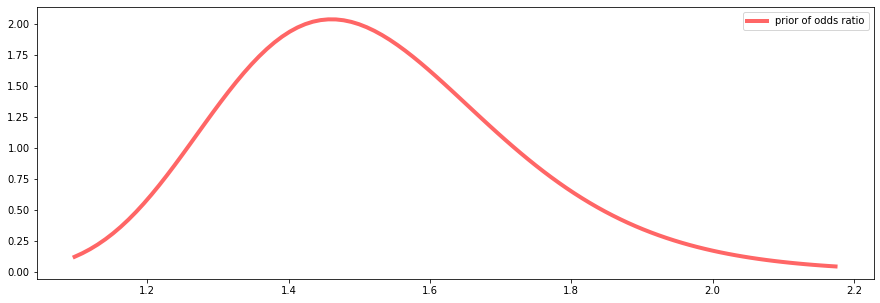

In [6]:
plot_dist(prior, label='prior of odds ratio');

In [7]:
prior.mean()

1.5202013400267558

## Generate demo data

In [8]:
np.random.seed(13)
uplift = prior.rvs()

A_true_rate = 0.4
B_true_rate = multiply_odds(A_true_rate, uplift)

uplift, B_true_rate

(1.3672065178013857, 0.4768427071133261)

In [9]:
N = 500

In [10]:
np.random.seed(1337)

A_observed = binom(n=N, p=A_true_rate).rvs()
B_observed = binom(n=N, p=B_true_rate).rvs()

A_observed, B_observed

(205, 237)

## Likelihood_A

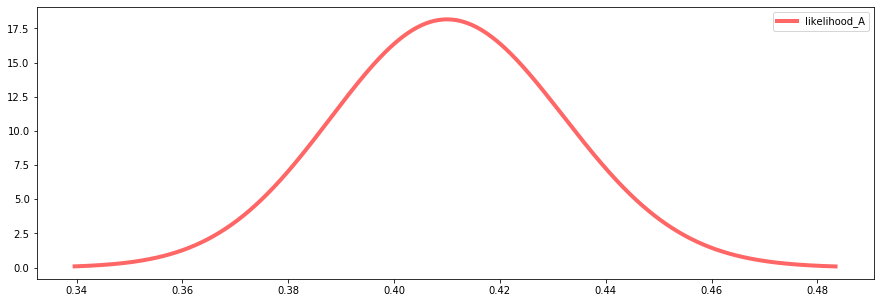

In [11]:
A_likelihood = beta(A_observed+1, N-A_observed+1)
plot_dist(A_likelihood, 1000, label='likelihood_A');

## Likelihood_B

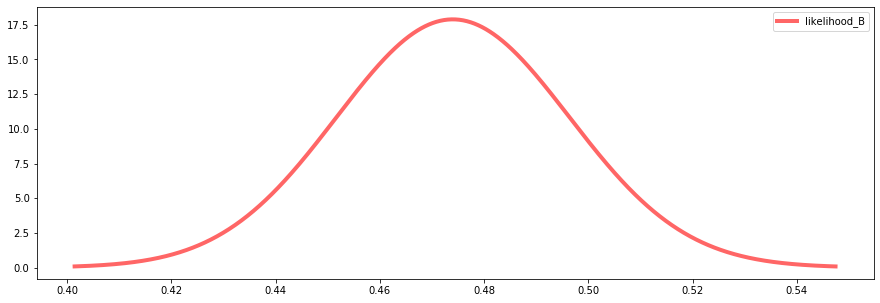

In [12]:
B_likelihood = beta(B_observed+1, N-B_observed+1)
plot_dist(B_likelihood, 1000, label='likelihood_B');

## Calculate likelihood over effect size from likelihoods over underlying rates

In [13]:
resolution = 100
pdf_sample_points = np.linspace(1/(resolution*2), 1 - 1/(resolution*2), resolution)

In [14]:
A_underlying_samples = A_likelihood.ppf(pdf_sample_points)
B_underlying_samples = B_likelihood.ppf(pdf_sample_points)

ratio_samples = [get_odds_ratio(B, A) for A in A_underlying_samples for B in B_underlying_samples]

ratio_likelihood = gaussian_kde(dataset=ratio_samples)

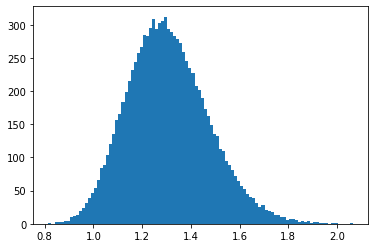

In [15]:
plt.hist(ratio_samples, bins=100);

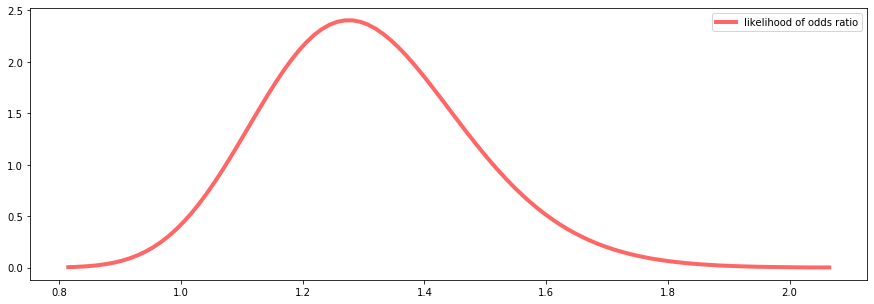

In [16]:
plot_dist(ratio_likelihood,
          x = np.linspace(min(ratio_samples),max(ratio_samples), 100),
          label='likelihood of odds ratio');

## Multiply likelihood by prior to get posterior

In [17]:
evaluation_range = np.linspace(min(ratio_samples), max(ratio_samples), 100)
posterior = [(x, prior.pdf(x) * ratio_likelihood.pdf(x)[0]) for x in evaluation_range]

In [18]:
x, y = zip(*posterior)
auc = trapz(y, x)

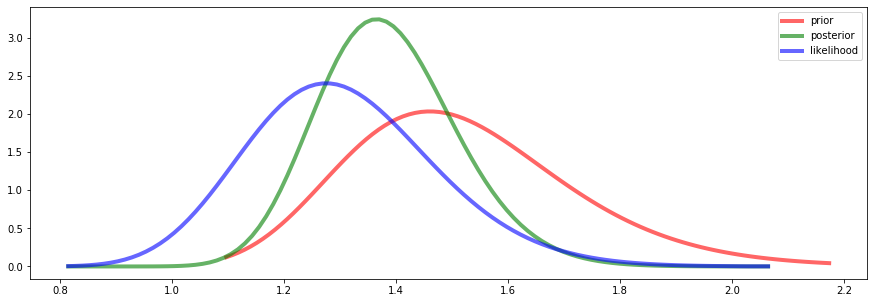

In [19]:
ax = plot_dist(prior, label='prior')
ax.plot(x, y/auc, '-g', lw=4, alpha=0.6, label='posterior');
plot_dist(ratio_likelihood,
          x = np.linspace(min(ratio_samples), max(ratio_samples), 100),
          style='-b',
          label='likelihood',
          ax=ax);

## Calculate posterior mean to give expected value of uplift

In [20]:
posterior_mean = np.dot(evaluation_range, y) / sum(y)

1.3869401455697286

In [24]:
print(f'Prior mean: {prior.mean():.3f}')
print(f'Actual uplift: {uplift:.3f}')
print(f'Posterior mean: {posterior_mean:.3f}')

Prior mean: 1.520
Actual uplift: 1.367
Posterior mean: 1.387
